<a href="https://colab.research.google.com/github/grosetta/rdkit_study/blob/main/%E5%8D%B7%E7%A7%AF%E7%A5%9E%E7%BB%8F%E7%BD%91%E7%BB%9C%EF%BC%88deepchem%E6%8F%90%E5%8F%96%E7%89%B9%E5%BE%81%EF%BC%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#文件头代码
import sys
from google.colab import drive
drive.mount('/content/gdrive')
sys.path.insert(0,"/content/gdrive/My Drive/Colab Notebooks/python_package/")

Mounted at /content/gdrive


In [2]:
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import os
import numpy as np
import pandas as pd
import tensorflow as tf

tf.random.set_seed(123)

import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.Chem import DataStructs
import deepchem as dc
from deepchem.molnet import load_tox21
from deepchem.models.graph_models import GraphConvModel

import dgl
import networkx as nx
import scipyimport dgl
import networkx as nx
import scipy

In [3]:
Excel_mols = "/content/gdrive/My Drive/data/tox21.xlsx"
sheet_names = list(pd.read_excel(Excel_mols, sheet_name=None))
df0 = pd.read_excel(Excel_mols, sheet_name=sheet_names[0])
df = pd.read_excel(Excel_mols, sheet_name=sheet_names[0])
columns = df.columns.tolist()
#过滤掉smile为空的行
df = df[df["smiles"] != '']

In [5]:
# input: X
train = df.sample(frac=0.8, replace=False, random_state=0)
valid = df[~df.index.isin(train.index)]

# input: y 
# 中位数填补
target=df["SR-p53"]
target.fillna(target.median(),inplace=True)
train_target = target.sample(frac=0.8, replace=False, random_state=0)
valid_target = target[~target.index.isin(train_target.index)]

In [7]:
# training set
# smiles list
list_name = list(train["mol_id"])
list_smiles = list(train["smiles"])
# smiles转换为mol分子
mols = [Chem.MolFromSmiles(i) for i in list_smiles]
mols = [rdkit.Chem.AddHs(i) for i in mols]
#实例化ConvMolFeaturizer（用卷积算法提取特征）
feature = dc.feat.ConvMolFeaturizer()
train_features = feature.featurize(mols)

In [10]:
#分子中原子的数量
conmol = train_features[1]
conmol.get_num_atoms()
#邻接矩阵
k = conmol.get_adjacency_list()
#k转换为正常矩阵
M = np.zeros((len(k), len(k)))
for i in range(len(k)):
    for j in k[i]:
        M[i,j] = 1
k = M
print(k)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.]]


DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


/content/gdrive/My Drive/Colab Notebooks/python_package/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


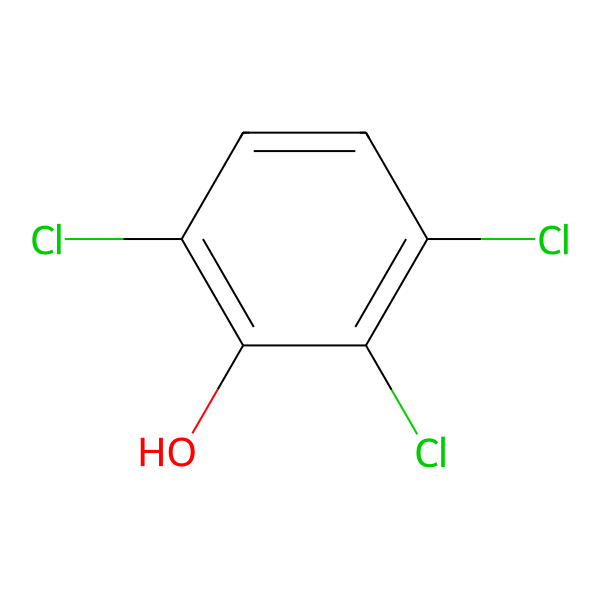

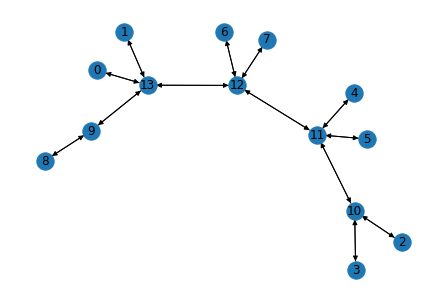

In [11]:
import dgl
import networkx as nx
import scipy
k = scipy.sparse.coo_matrix(k)
graph = dgl.DGLGraph(k)
nx.draw(graph.to_networkx(), with_labels=True)
mol1 = Chem.MolFromSmiles(list_smiles[0])
Draw.MolToImage(mol1, size=(600, 600))

In [12]:
# smiles list
list_name = list(valid["mol_id"])
list_smiles = list(valid["smiles"])
# smiles转换为mol分子
mols = [Chem.MolFromSmiles(i) for i in list_smiles]
mols = [rdkit.Chem.AddHs(i) for i in mols]
#实例化ConvMolFeaturizer
feature = dc.feat.ConvMolFeaturizer()
valid_features = feature.featurize(mols)

In [13]:
# 单任务分类
tox21_tasks = ["SR-p53"]

In [14]:
import tempfile
with tempfile.TemporaryDirectory() as data_dir:
    train_dataset = dc.data.DiskDataset.from_numpy(X=np.array(train_features), y=np.array(train_target), 
    tasks = tox21_tasks, data_dir='./dev')
    print(train_dataset)


import tempfile
with tempfile.TemporaryDirectory() as data_dir:
    valid_dataset = dc.data.DiskDataset.from_numpy(X=np.array(valid_features), y=np.array(valid_target),
    tasks = tox21_tasks, data_dir='./val')
    print(valid_dataset)

<DiskDataset X.shape: (6411,), y.shape: (6411,), w.shape: (6411,), task_names: ['SR-p53']>
<DiskDataset X.shape: (1603,), y.shape: (1603,), w.shape: (1603,), task_names: ['SR-p53']>


In [ ]:
# Fit models
metric = dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean, mode="classification")
# Batch size of models
batch_size = 50
model = GraphConvModel(len(tox21_tasks), batch_size=batch_size, mode='classification')
model.fit(train_dataset, nb_epoch=10)

In [16]:
print("Evaluating model")
train_scores = model.evaluate(train_dataset, [metric])
valid_scores = model.evaluate(valid_dataset, [metric])

print("Train scores")
print(train_scores)

print("Validation scores")
print(valid_scores)

Evaluating model
Train scores
{'mean-roc_auc_score': 0.899661304080553}
Validation scores
{'mean-roc_auc_score': 0.7052545919553592}


# 预测未知药物分子毒性

In [20]:
list_smiles = []
list_mols = Chem.SDMolSupplier('/content/gdrive/My Drive/data/molecules.sdf')
for mol in list_mols:
    smi = Chem.MolToSmiles(mol)
    list_smiles.append(smi)
    #print(smi)
    

# smiles转换为mol分子
mols = [Chem.MolFromSmiles(i) for i in list_smiles]
mols = [rdkit.Chem.AddHs(i) for i in mols]
#实例化ConvMolFeaturizer
feature = dc.feat.ConvMolFeaturizer()
test_features = feature.featurize(mols)


# CC(=O)Nc1ccc(O)cc1
mol1 = Chem.MolFromSmiles(list_smiles[0])
Draw.MolToImage(mol1, size=(600, 600))
#print(Draw.MolToImage(mol1, size=(600, 600)))
#Draw.ShowMol(mol1, size=(300,300), kekulize=False)


try:
    os.mkdir('./test')
except FileExistsError:
    pass

import tempfile
with tempfile.TemporaryDirectory() as data_dir:
    test_dataset = dc.data.DiskDataset.from_numpy(X=np.array(test_features), tasks = tox21_tasks, data_dir='./test')
    #print(test_dataset.X)


dict_label = {0:'无毒性', 1:'有毒性'}
# 概率预测模型
predictions_probability = model.predict(test_dataset)

for i, smi in enumerate(list_smiles):
    mol = Chem.MolFromSmiles(smi)
    Draw.MolToImage(mol, size=(600, 600))
    pred_label = dict_label[np.argmax(predictions_probability[i])]
    if pred_label=='无毒性':
        print('分子{}:\t'.format(i) + '这是一个AI预测' + pred_label + '的药物分子, 请放心做决策！')
    elif pred_label=='有毒性':
        print('分子{}:\t'.format(i) + '这是一个AI预测' + pred_label + '的药物分子, 请谨慎做决策！')
        Draw.MolToImage(mol, size=(600, 600))

分子0:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子1:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子2:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子3:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子4:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子5:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子6:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子7:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子8:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子9:	这是一个AI预测有毒性的药物分子, 请谨慎做决策！
分子10:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子11:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子12:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子13:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子14:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子15:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子16:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子17:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子18:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子19:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子20:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子21:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子22:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子23:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子24:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子25:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子26:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子27:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子28:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子29:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子30:	这是一个AI预测无毒性的药物分子, 请放心做决策！
分子31:	这是一个AI预测无毒性的